In [ ]:
!pip install torchtext==0.9.0

     |████████████████████████████████| 7.1 MB 33.5 MB/s 
     |████████████████████████████████| 735.5 MB 10 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.10.0
    Uninstalling torchtext-0.10.0:
      Successfully uninstalled torchtext-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.8.0 which is incompatible.


In [1]:
import pandas as pd
from datetime import datetime
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import emoji_def
import Slang
import re

from torch.utils.data import DataLoader
from itertools import combinations
from torchtext.vocab import GloVe

tokenizer = get_tokenizer('basic_english')


USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")

seed = 53113    
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if USE_CUDA:
    torch.cuda.manual_seed(seed)

Using cpu.


C:\Users\Daniel\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# from google.colab import drive 
# drive.mount('/content/gdrive')
# PATH = "gdrive/My Drive/nlp21/Project/"

PATH = r'C:\Users\Daniel\Documents\NLP Class\Project\\' 

In [38]:
device = 'cuda'
if device == 'cpu':
    VECTORS_CACHE_DIR = r'C:\Users\Daniel\Documents\NLP Class'
    # Please change above to your cache
else:
    VECTORS_CACHE_DIR = r'C:\Users\Daniel\Documents\NLP Class\Project\.vector_cache'
    # This is the default cache on Colab. Caching may not work
    # as expected on Colab.
    
#VECTORS_CACHE_DIR = None

In [3]:
train_data = pd.read_csv(PATH + "train_small_same_date_clean.csv")
valid_data = pd.read_csv(PATH + "test_small_same_date_clean.csv")

train_iter = list(zip(train_data['move'],train_data['body_lower_no_punc_stop_emoj_lem_url_slang'].astype(str)))
valid_iter = list(zip(valid_data['move'],valid_data['body_lower_no_punc_stop_emoj_lem_url_slang'].astype(str)))

In [95]:
train_data.iloc[1000]

Unnamed: 0                                                                                 1000
Unnamed: 0.1                                                                             337852
Unnamed: 0_x                                                                            1152545
body                                                       Yessss i just got 33 more shares💎🙌🙌🙌
created_utc                                                                2021-03-02T14:46:23Z
id                                                                                      gpggmme
kind                                                                                         t2
parent                                                                                t3_lwc2uk
subreddit                                                                                   GME
utc_raw                                                                            1614717983.0
utc_dt                                  

In [43]:
glove = GloVe(name='twitter.27B',dim=200) # could not find 300d version of these embeddings

100%|████████████████████████████▉| 1193513/1193514 [01:55<00:00, 10360.99it/s]


In [44]:
BATCH_SIZE = 64
def collate_into_cbow(batch):

    labels = torch.zeros(len(batch))
    examples = torch.zeros(len(batch), 200)
    
    for i in range(len(batch)):
        example = batch[i]
        label = example[0]
        if label == -1:
            label = 0
        words = tokenizer(example[1])
        vecs = glove.get_vecs_by_tokens(words)
        summed = vecs.sum(axis=0).reshape(1,-1)
        labels[i] = label
        examples[i] = summed # change to average
    
    return labels, examples

In [45]:
class LogRegClassifier(nn.Module):
    
    def __init__(self):
        super(LogRegClassifier, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Linear(200, 2,)

    def forward(self, bow_vec):
        return F.log_softmax(self.sigmoid(self.linear(bow_vec)), dim=1)
    
class DANClassifier(nn.Module):
    '''Using Iyyers specs of 3 300-d linear layers with ReLU activation'''
    def __init__(self):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(DANClassifier, self).__init__()
        
        self.linear1 = nn.Linear(200, 200,)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(200,200,)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(200,2,)

    def forward(self, bow_vec):
        return F.log_softmax(
            self.linear3(
                self.relu2(
                    self.linear2(
                        self.relu1(
                            self.linear1(bow_vec)
                        )
                    )
                )
            ), dim=1)

In [46]:
loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader):
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label.long())
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')
            
def get_accuracy(dataloader):
    hits = 0
    tot = 0
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            examples = batch[1]
            labels = batch[0]
            tot += len(labels)
            estimate = model.forward(examples)
            pred = torch.argmax(estimate, dim=1)
            # there's probably a better way to do this
            output = labels - pred
            for x in range(len(labels)):
                if (labels[x] == 0 and pred[x] == 0) or (labels[x] == 1 and pred[x] == 1):
                    hits +=1
            
    return hits/tot

In [59]:
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_cbow)
valid_dataloader = DataLoader(valid_iter, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_cbow)

model = DANClassifier()

In [60]:
EPOCHS = 100 # epoch
optimizer = optim.Adam(model.parameters(), lr=0.0001)

accuracies=[]
train_accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    accuracy = get_accuracy(valid_dataloader)
    train_accuracy = get_accuracy(train_dataloader)
    accuracies.append(accuracy)
    train_accuracies.append(train_accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print(f'After epoch {epoch} the training accuracy is {train_accuracy:.3f}.')
    print()

At iteration 500 the loss is 0.589.
At iteration 1000 the loss is 0.608.
At iteration 1500 the loss is 0.584.
At iteration 2000 the loss is 0.588.
At iteration 2500 the loss is 0.693.
At iteration 3000 the loss is 0.651.
At iteration 3500 the loss is 0.610.

After epoch 1 the validation accuracy is 0.369.
After epoch 1 the training accuracy is 0.674.

At iteration 500 the loss is 0.540.
At iteration 1000 the loss is 0.613.
At iteration 1500 the loss is 0.654.
At iteration 2000 the loss is 0.569.
At iteration 2500 the loss is 0.658.
At iteration 3000 the loss is 0.663.
At iteration 3500 the loss is 0.596.

After epoch 2 the validation accuracy is 0.369.
After epoch 2 the training accuracy is 0.676.

At iteration 500 the loss is 0.615.
At iteration 1000 the loss is 0.542.
At iteration 1500 the loss is 0.672.
At iteration 2000 the loss is 0.609.
At iteration 2500 the loss is 0.638.
At iteration 3000 the loss is 0.661.
At iteration 3500 the loss is 0.607.

After epoch 3 the validation accu

At iteration 1000 the loss is 0.446.
At iteration 1500 the loss is 0.423.
At iteration 2000 the loss is 0.411.
At iteration 2500 the loss is 0.584.
At iteration 3000 the loss is 0.476.
At iteration 3500 the loss is 0.540.

After epoch 24 the validation accuracy is 0.407.
After epoch 24 the training accuracy is 0.752.

At iteration 500 the loss is 0.501.
At iteration 1000 the loss is 0.588.
At iteration 1500 the loss is 0.508.
At iteration 2000 the loss is 0.528.
At iteration 2500 the loss is 0.566.
At iteration 3000 the loss is 0.490.
At iteration 3500 the loss is 0.536.

After epoch 25 the validation accuracy is 0.419.
After epoch 25 the training accuracy is 0.757.

At iteration 500 the loss is 0.461.
At iteration 1000 the loss is 0.482.
At iteration 1500 the loss is 0.525.
At iteration 2000 the loss is 0.465.
At iteration 2500 the loss is 0.415.
At iteration 3000 the loss is 0.624.
At iteration 3500 the loss is 0.565.

After epoch 26 the validation accuracy is 0.412.
After epoch 26 t

At iteration 1500 the loss is 0.367.
At iteration 2000 the loss is 0.381.
At iteration 2500 the loss is 0.526.
At iteration 3000 the loss is 0.458.
At iteration 3500 the loss is 0.417.

After epoch 47 the validation accuracy is 0.431.
After epoch 47 the training accuracy is 0.805.

At iteration 500 the loss is 0.465.
At iteration 1000 the loss is 0.438.
At iteration 1500 the loss is 0.457.
At iteration 2000 the loss is 0.370.
At iteration 2500 the loss is 0.449.
At iteration 3000 the loss is 0.459.
At iteration 3500 the loss is 0.491.

After epoch 48 the validation accuracy is 0.424.
After epoch 48 the training accuracy is 0.805.

At iteration 500 the loss is 0.448.
At iteration 1000 the loss is 0.424.
At iteration 1500 the loss is 0.527.
At iteration 2000 the loss is 0.375.
At iteration 2500 the loss is 0.520.
At iteration 3000 the loss is 0.341.
At iteration 3500 the loss is 0.412.

After epoch 49 the validation accuracy is 0.425.
After epoch 49 the training accuracy is 0.807.

At it

At iteration 2000 the loss is 0.381.
At iteration 2500 the loss is 0.353.
At iteration 3000 the loss is 0.383.
At iteration 3500 the loss is 0.306.

After epoch 70 the validation accuracy is 0.432.
After epoch 70 the training accuracy is 0.836.

At iteration 500 the loss is 0.391.
At iteration 1000 the loss is 0.327.
At iteration 1500 the loss is 0.424.
At iteration 2000 the loss is 0.326.
At iteration 2500 the loss is 0.276.
At iteration 3000 the loss is 0.287.
At iteration 3500 the loss is 0.435.

After epoch 71 the validation accuracy is 0.434.
After epoch 71 the training accuracy is 0.834.

At iteration 500 the loss is 0.344.
At iteration 1000 the loss is 0.336.
At iteration 1500 the loss is 0.360.
At iteration 2000 the loss is 0.324.
At iteration 2500 the loss is 0.383.
At iteration 3000 the loss is 0.308.
At iteration 3500 the loss is 0.358.

After epoch 72 the validation accuracy is 0.438.
After epoch 72 the training accuracy is 0.839.

At iteration 500 the loss is 0.406.
At ite

At iteration 2500 the loss is 0.345.
At iteration 3000 the loss is 0.440.
At iteration 3500 the loss is 0.339.

After epoch 93 the validation accuracy is 0.445.
After epoch 93 the training accuracy is 0.857.

At iteration 500 the loss is 0.274.
At iteration 1000 the loss is 0.318.
At iteration 1500 the loss is 0.326.
At iteration 2000 the loss is 0.294.
At iteration 2500 the loss is 0.365.
At iteration 3000 the loss is 0.257.
At iteration 3500 the loss is 0.421.

After epoch 94 the validation accuracy is 0.438.
After epoch 94 the training accuracy is 0.858.

At iteration 500 the loss is 0.261.
At iteration 1000 the loss is 0.330.
At iteration 1500 the loss is 0.262.
At iteration 2000 the loss is 0.431.
At iteration 2500 the loss is 0.334.
At iteration 3000 the loss is 0.385.
At iteration 3500 the loss is 0.257.

After epoch 95 the validation accuracy is 0.435.
After epoch 95 the training accuracy is 0.857.

At iteration 500 the loss is 0.241.
At iteration 1000 the loss is 0.368.
At ite

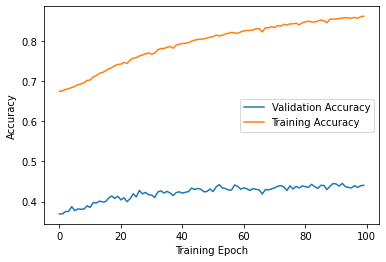

In [64]:
plt.plot(accuracies, label="Validation Accuracy")
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Training Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [65]:
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_cbow)
valid_dataloader = DataLoader(valid_iter, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_cbow)

model = LogRegClassifier()

In [66]:
EPOCHS = 100 # epoch
optimizer = optim.Adam(model.parameters(), lr=0.0001)

accuracies=[]
train_accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    accuracy = get_accuracy(valid_dataloader)
    train_accuracy = get_accuracy(train_dataloader)
    accuracies.append(accuracy)
    train_accuracies.append(train_accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print(f'After epoch {epoch} the training accuracy is {train_accuracy:.3f}.')
    print()

At iteration 500 the loss is 0.615.
At iteration 1000 the loss is 0.759.
At iteration 1500 the loss is 0.648.
At iteration 2000 the loss is 0.663.
At iteration 2500 the loss is 0.644.
At iteration 3000 the loss is 0.625.
At iteration 3500 the loss is 0.651.

After epoch 1 the validation accuracy is 0.368.
After epoch 1 the training accuracy is 0.670.

At iteration 500 the loss is 0.641.
At iteration 1000 the loss is 0.678.
At iteration 1500 the loss is 0.720.
At iteration 2000 the loss is 0.677.
At iteration 2500 the loss is 0.552.
At iteration 3000 the loss is 0.725.
At iteration 3500 the loss is 0.627.

After epoch 2 the validation accuracy is 0.367.
After epoch 2 the training accuracy is 0.672.

At iteration 500 the loss is 0.630.
At iteration 1000 the loss is 0.588.
At iteration 1500 the loss is 0.617.
At iteration 2000 the loss is 0.629.
At iteration 2500 the loss is 0.680.
At iteration 3000 the loss is 0.616.
At iteration 3500 the loss is 0.641.

After epoch 3 the validation accu

At iteration 1000 the loss is 0.593.
At iteration 1500 the loss is 0.590.
At iteration 2000 the loss is 0.602.
At iteration 2500 the loss is 0.644.
At iteration 3000 the loss is 0.611.
At iteration 3500 the loss is 0.704.

After epoch 24 the validation accuracy is 0.367.
After epoch 24 the training accuracy is 0.672.

At iteration 500 the loss is 0.541.
At iteration 1000 the loss is 0.693.
At iteration 1500 the loss is 0.662.
At iteration 2000 the loss is 0.625.
At iteration 2500 the loss is 0.633.
At iteration 3000 the loss is 0.633.
At iteration 3500 the loss is 0.657.

After epoch 25 the validation accuracy is 0.367.
After epoch 25 the training accuracy is 0.672.

At iteration 500 the loss is 0.566.
At iteration 1000 the loss is 0.558.
At iteration 1500 the loss is 0.636.
At iteration 2000 the loss is 0.718.
At iteration 2500 the loss is 0.576.
At iteration 3000 the loss is 0.593.
At iteration 3500 the loss is 0.606.

After epoch 26 the validation accuracy is 0.367.
After epoch 26 t

At iteration 1500 the loss is 0.626.
At iteration 2000 the loss is 0.577.
At iteration 2500 the loss is 0.643.
At iteration 3000 the loss is 0.633.
At iteration 3500 the loss is 0.593.

After epoch 47 the validation accuracy is 0.367.
After epoch 47 the training accuracy is 0.672.

At iteration 500 the loss is 0.572.
At iteration 1000 the loss is 0.636.
At iteration 1500 the loss is 0.590.
At iteration 2000 the loss is 0.594.
At iteration 2500 the loss is 0.641.
At iteration 3000 the loss is 0.717.
At iteration 3500 the loss is 0.594.

After epoch 48 the validation accuracy is 0.367.
After epoch 48 the training accuracy is 0.672.

At iteration 500 the loss is 0.639.
At iteration 1000 the loss is 0.638.
At iteration 1500 the loss is 0.639.
At iteration 2000 the loss is 0.677.
At iteration 2500 the loss is 0.641.
At iteration 3000 the loss is 0.621.
At iteration 3500 the loss is 0.612.

After epoch 49 the validation accuracy is 0.367.
After epoch 49 the training accuracy is 0.672.

At it

At iteration 2000 the loss is 0.620.
At iteration 2500 the loss is 0.643.
At iteration 3000 the loss is 0.611.
At iteration 3500 the loss is 0.626.

After epoch 70 the validation accuracy is 0.368.
After epoch 70 the training accuracy is 0.672.

At iteration 500 the loss is 0.574.
At iteration 1000 the loss is 0.618.
At iteration 1500 the loss is 0.562.
At iteration 2000 the loss is 0.617.
At iteration 2500 the loss is 0.637.
At iteration 3000 the loss is 0.630.
At iteration 3500 the loss is 0.638.

After epoch 71 the validation accuracy is 0.368.
After epoch 71 the training accuracy is 0.672.

At iteration 500 the loss is 0.571.
At iteration 1000 the loss is 0.644.
At iteration 1500 the loss is 0.598.
At iteration 2000 the loss is 0.598.
At iteration 2500 the loss is 0.649.
At iteration 3000 the loss is 0.584.
At iteration 3500 the loss is 0.657.

After epoch 72 the validation accuracy is 0.368.
After epoch 72 the training accuracy is 0.672.

At iteration 500 the loss is 0.596.
At ite

At iteration 2500 the loss is 0.598.
At iteration 3000 the loss is 0.730.
At iteration 3500 the loss is 0.617.

After epoch 93 the validation accuracy is 0.368.
After epoch 93 the training accuracy is 0.672.

At iteration 500 the loss is 0.639.
At iteration 1000 the loss is 0.519.
At iteration 1500 the loss is 0.566.
At iteration 2000 the loss is 0.622.
At iteration 2500 the loss is 0.672.
At iteration 3000 the loss is 0.663.
At iteration 3500 the loss is 0.550.

After epoch 94 the validation accuracy is 0.368.
After epoch 94 the training accuracy is 0.672.

At iteration 500 the loss is 0.718.
At iteration 1000 the loss is 0.590.
At iteration 1500 the loss is 0.635.
At iteration 2000 the loss is 0.732.
At iteration 2500 the loss is 0.602.
At iteration 3000 the loss is 0.642.
At iteration 3500 the loss is 0.664.

After epoch 95 the validation accuracy is 0.368.
After epoch 95 the training accuracy is 0.672.

At iteration 500 the loss is 0.633.
At iteration 1000 the loss is 0.641.
At ite